## Packages

In [2]:
import pyvinecopulib as pvcl

import numpy as np
import pandas as pd
import scipy.interpolate as interpolate
import scipy.optimize as optimize

import datetime
import pandas_datareader as pdr

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data access

In [ ]:
# getting financial data from yahoo finance
start = datetime.datetime(2016,1,1)
end = datetime.datetime(2017,1,1) # datetime.date.today()
symbols = ["AAPL", "IBM", "GOOGL", "AMZN"]
panel = pdr.get_data_yahoo(symbols, start, end).transpose(1,0,2)
df = panel.to_frame().xs('Close', axis=0, drop_level=True)
df

In [4]:
# generating a multivariate normal distribution
mean = [0., 0., 0., 0.]
matrixSize = 4 
A = np.random.rand(matrixSize, matrixSize)
cov = np.dot(A, A.transpose()) # symmetric positive-semidefinite matrix
df = pd.DataFrame(np.random.multivariate_normal(mean, cov, 100).T, index=list('ABCD'))

In [5]:
# multivariate geometric brownian motion
dates = pd.date_range('20170101', periods=365).strftime('%Y-%m-%d')
assets = list('ABCD'); N_assets = len(assets)
S0 = np.random.uniform(100, 200, size=4)
drift = 0.1 * np.random.randn(4)
sigma = 0.2 * np.random.uniform(0.,.5,4)
T = 1; N = len(dates)-1; tau = T / N # timestep
S = S0 * np.exp(
        np.cumsum((drift - 0.5 * sigma ** 2) * tau + sigma * np.sqrt(tau) * np.random.multivariate_normal(mean, cov, N), axis=0)
    )
S = np.insert(S, 0, S0, axis=0)
df = pd.DataFrame(S.T, index=list('ABCD'), columns=dates)
df

,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
A,123.274875,123.436552,123.476848,123.354088,123.315783,123.531510,123.423601,123.223188,123.075114,123.077435,...,111.544363,111.417733,111.352605,111.227016,111.170646,110.855262,110.762134,110.826037,110.976484,110.780011
B,172.700308,172.966462,172.820201,172.917790,172.865205,173.243568,173.430318,173.609042,173.384888,173.380929,...,185.852622,185.917953,185.634653,185.651061,185.981565,185.968577,185.968038,186.102249,186.056054,186.125062
C,113.068809,113.177875,113.082666,113.042047,113.027984,113.176237,113.206007,113.153745,113.048766,113.087867,...,109.497677,109.473639,109.362796,109.358059,109.530217,109.405071,109.382931,109.417436,109.497946,109.489400
D,156.830454,157.132630,156.399618,156.443555,156.368142,156.870134,157.473190,157.728237,157.347611,157.489925,...,161.940680,162.155990,161.594172,162.012782,163.317802,163.533383,163.605367,163.646993,163.726408,164.365615


## Data Setup

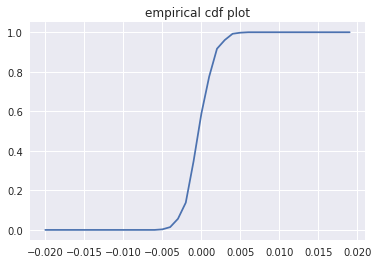

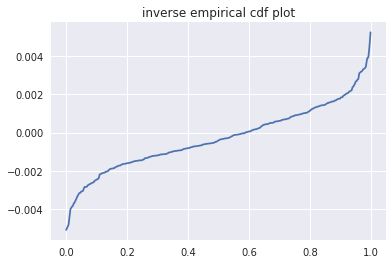

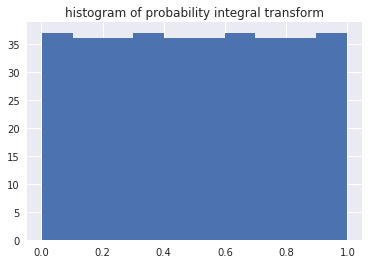

In [6]:
# log returns
returns = np.log(df).diff(axis=1).iloc[:,1:]

def empirical_cdf(data):
    return data.dropna().rank(axis=1) / (len(data.columns) + 1)

# empirical cdf
emp = empirical_cdf(returns)

# empirical cdf plot 
cdf = interpolate.interp1d(returns.iloc[0,:], emp.iloc[0,:], fill_value="extrapolate")
x = np.arange(-.02, .02, 0.001)
y = cdf(x)
y[y<0]=0; y[y>1]=1
f = plt.figure(1)
plt.title("empirical cdf plot")
plt.plot(x, y)

# inverse cdf
def inverse_cdf(cdf, y):
    def func(x):
        return cdf(x) - y
    return optimize.bisect(func, -1, 1)

v_inverse_cdf = np.vectorize(inverse_cdf)

# inverse empirical cdf plot
x = np.arange(0., 1., 0.001)
y = v_inverse_cdf(cdf, x)
g = plt.figure(2)
plt.title("inverse empirical cdf plot")
plt.plot(x, y)

# empirical cdf histogram
h = plt.figure(3)
plt.title("histogram of probability integral transform")
emp.iloc[0,:].hist(bins=10)

plt.show()

## Fitting a vine copula

In [7]:
# fit general vine copula
fitted = pvcl.vinecop(emp.values)

In [37]:
np.savetxt("foo.csv", emp.values, delimiter=",")
type(emp.values)

numpy.ndarray

In [35]:
emp.values

array([[ 0.81643836,  0.64109589,  0.34794521, ...,  0.68767123,
         0.82465753,  0.16712329],
       [ 0.87671233,  0.1890411 ,  0.61917808, ...,  0.6739726 ,
         0.35342466,  0.54794521],
       [ 0.83561644,  0.24931507,  0.40273973, ...,  0.64383562,
         0.76712329,  0.53972603],
       [ 0.73150685,  0.04383562,  0.51506849, ...,  0.50958904,
         0.55342466,  0.90410959]])

In [27]:
a = pvcl.vinecop(emp.values)
a.matrix

array([[3, 4, 1, 2],
       [3, 1, 4, 0],
       [1, 3, 0, 0],
       [1, 0, 0, 0]], dtype=uint64)

In [8]:
# fit vine copula with controls
fitted = pvcl.vinecop(4)

fit_controls = pvcl.vinecop_fit_controls()
fit_controls.family_set = [
    pvcl.bicop_family.indep,
    pvcl.bicop_family.gaussian,
    pvcl.bicop_family.student,
    pvcl.bicop_family.clayton,
    pvcl.bicop_family.gumbel,
    pvcl.bicop_family.frank,
]
fit_controls.truncation_level = 2

fitted.select_all(emp.values, fit_controls)

In [9]:
fitted.matrix

array([[3, 4, 1, 2],
       [3, 1, 4, 0],
       [1, 3, 0, 0],
       [1, 0, 0, 0]], dtype=uint64)

In [10]:
# access vine copula attributes
print("R-vine matrix:")
print(fitted.matrix)
print("\nPair copula family for edge 2 in tree 0:")
print(fitted.family(0,2))
print("\nParameters:")
print(fitted.parameters(0,2))
print("\nRotation:")
print(fitted.rotation(0,2))

R-vine matrix:
[[3 4 1 2]
 [3 1 4 0]
 [1 3 0 0]
 [1 0 0 0]]

Pair copula family for edge 2 in tree 0:
gaussian

Parameters:
[0.861109192343859]

Rotation:
0


## Simulating from a vine copula

In [11]:
num_draws = 364
future_dates =  pd.date_range('20180101', periods=364).strftime('%Y-%m-%d')
sim_unif = pd.DataFrame(fitted.simulate(num_draws), index=df.index.values, columns=future_dates)
sim_unif

,2018-01-01,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-08,2018-01-09,2018-01-10,...,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30
A,0.700391,0.107152,0.017649,0.726838,0.097337,0.112385,0.708079,0.437875,0.312151,0.981217,...,0.105107,0.482179,0.516570,0.447722,0.872500,0.283577,0.313107,0.249152,0.214294,0.969724
B,0.352816,0.354296,0.096715,0.313951,0.657994,0.767339,0.539962,0.519934,0.180233,0.700454,...,0.033741,0.325730,0.182995,0.118146,0.536124,0.087620,0.045768,0.565511,0.267371,0.935740
C,0.528327,0.298750,0.060044,0.398257,0.240577,0.273214,0.522044,0.474306,0.397096,0.894332,...,0.037395,0.272817,0.339203,0.216526,0.941872,0.140715,0.071582,0.579495,0.405101,0.961227
D,0.354957,0.776340,0.336155,0.143237,0.474223,0.527505,0.341704,0.489556,0.328402,0.402173,...,0.090021,0.185955,0.135250,0.165113,0.744003,0.028173,0.047930,0.884228,0.555629,0.765901


In [12]:
# flip uniform marginals into returns
sim_returns = sim_unif.copy()

for i in range(len(df.index)):
    cdf = interpolate.interp1d(returns.iloc[i,:], emp.iloc[i,:], fill_value="extrapolate")
    sim_returns_slice = v_inverse_cdf(cdf, sim_unif.iloc[i,:])
    sim_returns.iloc[i,:] = sim_returns_slice

sim_returns

,2018-01-01,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-08,2018-01-09,2018-01-10,...,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30
A,0.000609,-0.002367,-0.003908,0.000729,-0.002491,-0.002168,0.000657,-0.000678,-0.001143,0.003387,...,-0.002414,-0.000542,-0.000319,-0.000633,0.001623,-0.001227,-0.001143,-0.001442,-0.001553,0.003193
B,-0.000251,-0.000243,-0.001284,-0.000355,0.000697,0.001051,0.000357,0.000309,-0.000871,0.000838,...,-0.001807,-0.000313,-0.000869,-0.001162,0.000355,-0.001355,-0.001749,0.000444,-0.000510,0.001964
C,-0.000103,-0.000650,-0.001906,-0.000366,-0.000862,-0.000723,-0.000105,-0.000210,-0.000367,0.001292,...,-0.002148,-0.000723,-0.000516,-0.000957,0.001645,-0.001303,-0.001780,0.000071,-0.000356,0.002062
D,-0.000866,0.002349,-0.000976,-0.003200,0.000080,0.000324,-0.000943,0.000157,-0.001089,-0.000491,...,-0.003930,-0.002531,-0.003304,-0.002815,0.002014,-0.005147,-0.004584,0.003649,0.000489,0.002247


In [14]:
# flip simulated returns into underlying price paths
cum_returns = np.cumsum(sim_returns, axis=1)
temp = (cum_returns.transpose() + np.log(df.iloc[:,-1])).transpose()
price_paths = np.exp(temp)
#price_paths.insert(0, dates[-1], df.ix[:,-1])
price_paths

,2018-01-01,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-08,2018-01-09,2018-01-10,...,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30
A,110.847533,110.585472,110.154129,110.234475,109.960255,109.722081,109.794242,109.719812,109.594464,109.966315,...,99.401005,99.347105,99.315414,99.252569,99.413772,99.291836,99.178458,99.035566,98.881919,99.198175
B,186.078405,186.033187,185.794441,185.728510,185.858092,186.053543,186.119901,186.177331,186.015159,186.171056,...,198.600622,198.538476,198.366046,198.135666,198.206101,197.937692,197.591842,197.679583,197.578876,197.967271
C,109.478147,109.406994,109.198649,109.158637,109.064576,108.985739,108.974345,108.951494,108.911493,109.052245,...,105.886084,105.809505,105.754961,105.653855,105.827800,105.689978,105.502000,105.509498,105.471965,105.689707
D,164.223286,164.609487,164.448854,163.923408,163.936591,163.989739,163.835123,163.860850,163.682557,163.602262,...,173.256081,172.818124,172.248071,171.763894,172.110134,171.226610,170.443460,171.066475,171.150201,171.535137


## Plotting calibration and simulation data

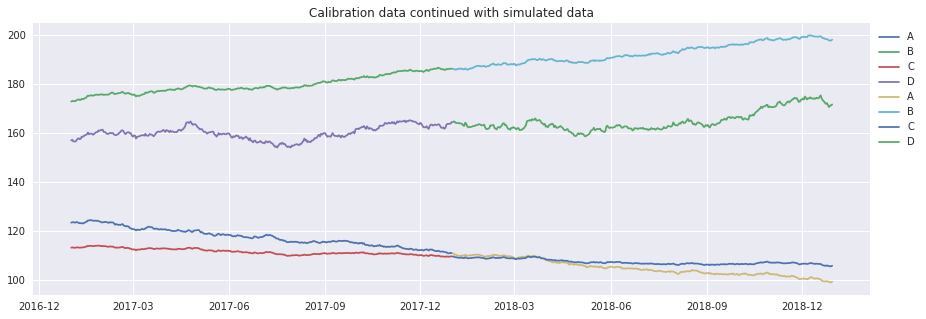

In [15]:
# comparing input price path with simulated price path
plt.figure(figsize=(15,5))
plt.title('Calibration data continued with simulated data')
ax = plt.subplot(111)

for i in range(4):
    plt.plot_date(df.iloc[i,:].index, df.iloc[i,:].values, '-', label=df.iloc[i,:].name)

for i in range(4):
    plt.plot_date(price_paths.iloc[i,:].index, price_paths.iloc[i,:].values, '-', 
                  label=price_paths.iloc[i,:].name)
    
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

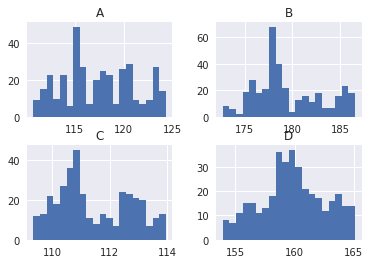

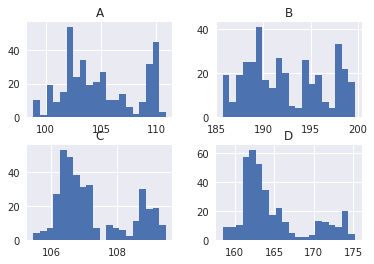

In [19]:
# comparing actual returns and simulated returns univariate distributions
df.T.hist(bins=20)
price_paths.T.hist(bins=20)
f.tight_layout()

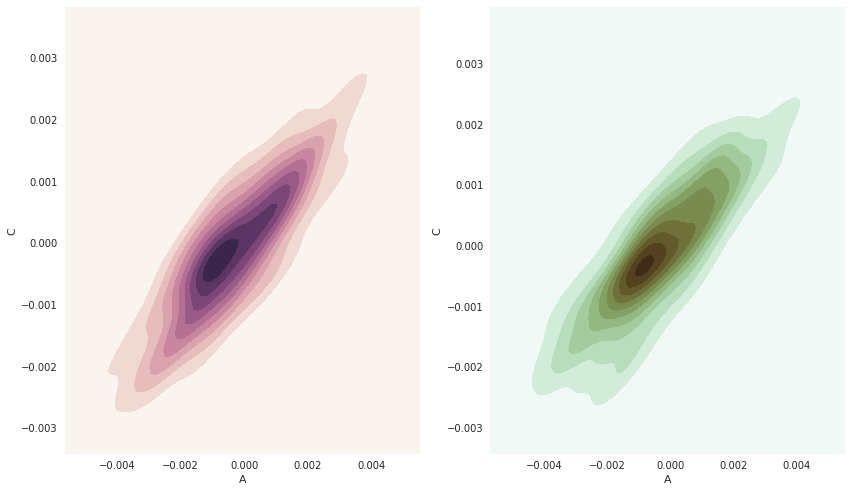

In [20]:
# comparing actual returns and simulated returns bivariate distributions
sns.set(style="dark")
f, axes = plt.subplots(1, 2, figsize=(12, 7))

data = [returns.loc['A'], returns.loc['C'], sim_returns.loc['A'], sim_returns.loc['C']]

for ax, s in zip(axes.flat, range(2)):
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)
    sns.kdeplot(data[2*s],data[2*s+1], cmap=cmap, shade=True,cut=1, ax=ax)

f.tight_layout()